<h3>NFL Game Simulation - Basic Example</h3>

<p>
  <b>Description</b>: Estimate Win Probabilities based on Points For and Points Against from the Regular Season.
</p>

<p>
  <b>Question(s)</b>: Which team has the better chance of winning the game?
</p>

<br />
<br />
<br />

In [41]:
import random

import numpy as np
import pandas as pd
from scipy.stats import norm

In [49]:
year = 2022

In [58]:
df = pd.read_csv(f'../../data/nfl/pfr-{year}-games.csv')


regular_season = pd.concat(
    [
        df[['Week', 'Winner/tie', 'Pts', 'Pts.1']].rename(columns={
            'Week': 'week',
            'Winner/tie': 'team',
            'Pts': 'pf',
            'Pts.1': 'pa',
        }),
        df[['Week', 'Loser/tie', 'Pts', 'Pts.1']].rename(columns={
            'Week': 'week',
            'Loser/tie': 'team',
            'Pts.1': 'pf',
            'Pts': 'pa',
        }),
    ]
).sort_values(['week'])

regular_season.head()

,week,team,pf,pa
0,1,Buffalo Bills,31,10
13,1,Las Vegas Raiders,19,24
12,1,Tennessee Titans,20,21
11,1,Green Bay Packers,7,23
10,1,Arizona Cardinals,21,44


In [51]:
regular_season.describe()

,week,pf,pa
count,542.000000,542.000000,542.000000
mean,9.450185,21.881919,21.881919
std,5.292578,9.307883,9.307883
min,1.000000,0.000000,0.000000
25%,5.000000,16.000000,16.000000
50%,9.000000,21.000000,21.000000
75%,14.000000,27.000000,27.000000
max,18.000000,54.000000,54.000000


In [52]:
ratings = regular_season.groupby('team').mean()[['pf', 'pa']]
ratings.loc['Cincinnati Bengals']

pf    26.125
pa    20.125
Name: Cincinnati Bengals, dtype: float64

In [60]:
ratings

,pf,pa
team,,
Arizona Cardinals,20.000000,26.411765
Atlanta Falcons,21.470588,22.705882
Baltimore Ravens,20.588235,18.529412
Buffalo Bills,28.437500,17.875000
Carolina Panthers,20.411765,22.000000
Chicago Bears,19.176471,27.235294
Cincinnati Bengals,26.125000,20.125000
Cleveland Browns,21.235294,22.411765
Dallas Cowboys,27.470588,20.117647


In [53]:
avg_points = regular_season['pf'].mean()
score_std = regular_season['pf'].std()

print(avg_points, score_std)

21.881918819188193 9.307882574027339


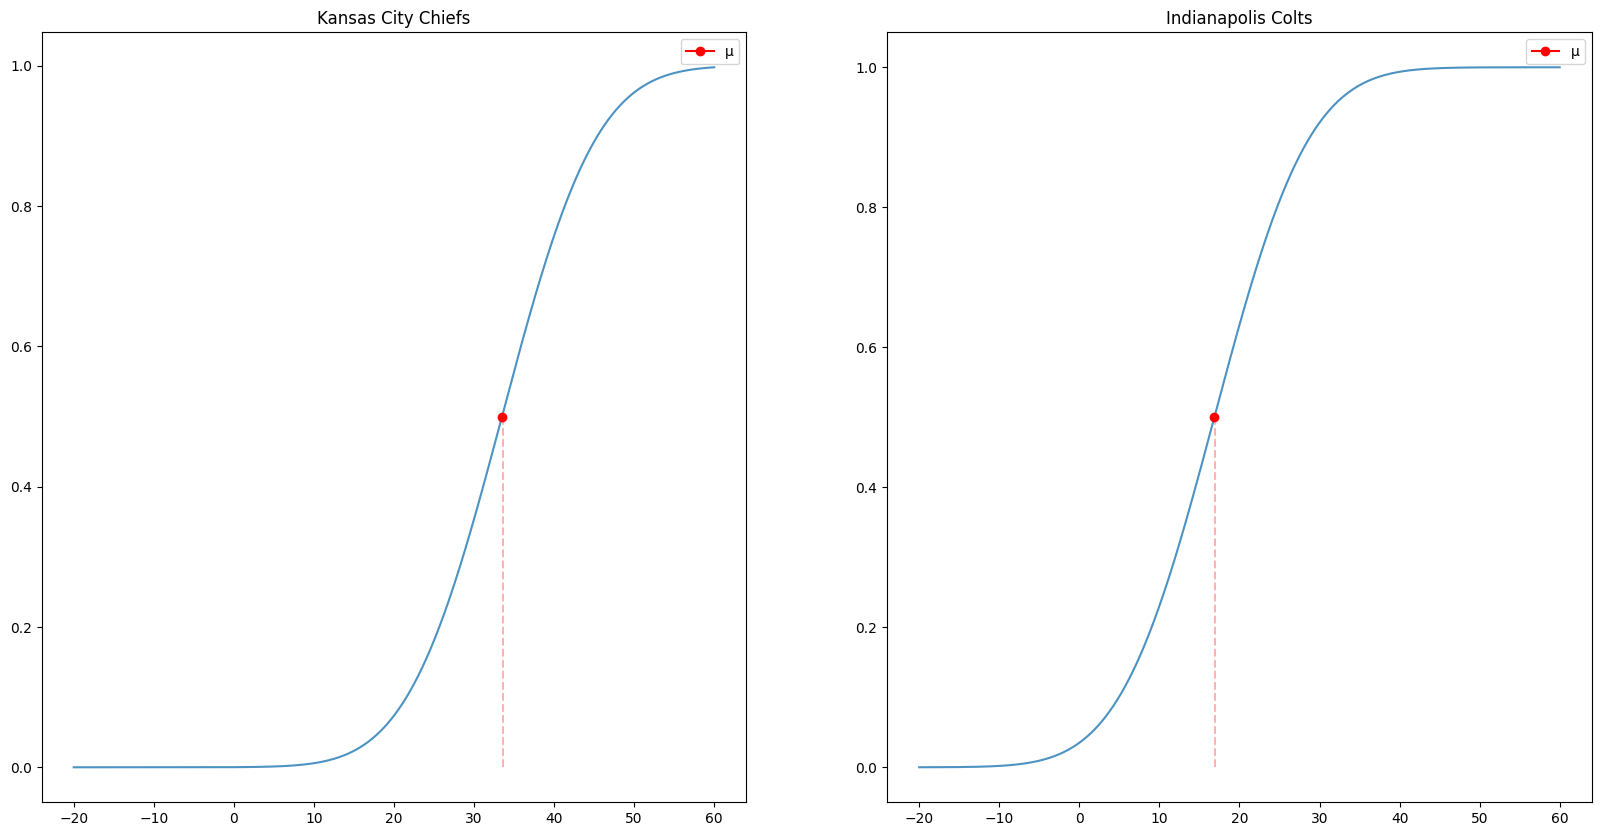

In [59]:
import matplotlib.pyplot as plt

def plot_game_cdfs(t1, t2):

  t1_pf, t1_pa = ratings.loc[t1][['pf', 'pa']]
  t2_pf, t2_pa = ratings.loc[t2][['pf', 'pa']]

  _, ax = plt.subplots(1, 2, figsize=(20, 10))

  x = np.linspace(-20, 60, 10000)
  team1_mu = (t1_pf * t2_pa) / avg_points
  vals_1 = norm.cdf(x, team1_mu, score_std)

  ax[0].set_title(t1)
  ax[0].plot(x, vals_1, alpha=.8)
  ax[0].plot(team1_mu, .5, color='red', label='μ', marker='o')
  ax[0].vlines([team1_mu+.1], 0, .5, colors='red', alpha=.3, linestyles='dashed')
  ax[0].legend()

  team2_mu = (t2_pf * t1_pa) / avg_points
  vals_2 = norm.cdf(x, team2_mu, score_std)

  ax[1].set_title(t2)
  ax[1].plot(x, vals_2, alpha=.8)
  ax[1].plot(team2_mu, .5, color='red', label='μ', marker='o')
  ax[1].vlines([team2_mu+.1], 0, .5, colors='red', alpha=.3, linestyles='dashed')
  ax[1].legend()

  plt.show()

plot_game_cdfs(
  'Kansas City Chiefs',
  'Indianapolis Colts'
)

In [69]:
class Match:
    def __init__(self, regular_season, simulations = 10000):
        self._ratings = regular_season.groupby('team').mean()[['pf', 'pa']]
        self._avg_points=regular_season['pf'].mean()
        self._score_std=regular_season['pf'].std()
        self._simulations = simulations

    def simulate(self, t1, t2):
        def get_team_data(team):
            return self._ratings.loc[team][['pf', 'pa']]

        def compute_expected_points(off, opposing_def):
            return (off * opposing_def) / self._avg_points

        t1_pf, t1_pa = get_team_data(t1)
        t2_pf, t2_pa = get_team_data(t2)

        team1_mu = compute_expected_points(t1_pf, t2_pa)
        team2_mu = compute_expected_points(t2_pf, t1_pa)
        
        scores = [
            self._play_game(team1_mu, team2_mu)
            for _ in range(self._simulations)
        ]

        t1_wins = sum(t1_score > t2_score for t1_score, t2_score in scores)
        t1_win_percentage = t1_wins / self._simulations

        return {
           't1': t1_win_percentage,
           't2': 1 - t1_win_percentage
        }

    def _play_game(self, team1_mu, team2_mu):
        return (
            round(norm.ppf(random.random(), team1_mu, self._score_std), 2),
            round(norm.ppf(random.random(), team2_mu, self._score_std), 2),
        )

match = Match(
  regular_season=regular_season,
  simulations=10000
)

schedule = [
    ('Kansas City Chiefs', 'Cincinnati Bengals'),
    ('Kansas City Chiefs', 'Indianapolis Colts')
]

print('-' * 100)
for team1, team2 in schedule:
      
    observations = match.simulate(team1, team2)

    t1 = round(observations['t1'] * 100, 2)
    t2 = round(observations['t2'] * 100, 2)

    print(f'{team1}: {t1}')
    print(f'{team2}: {t2}')
    print('-' * 100)

----------------------------------------------------------------------------------------------------
Kansas City Chiefs: 53.0
Cincinnati Bengals: 47.0
----------------------------------------------------------------------------------------------------
Kansas City Chiefs: 89.45
Indianapolis Colts: 10.55
----------------------------------------------------------------------------------------------------
